<a href="https://colab.research.google.com/github/AbhishekSinghKushwah7/Plant-Disease-Identification-via-Deep-Learning/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 2**

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/new_drive')

Drive already mounted at /content/new_drive; to attempt to forcibly remount, call drive.mount("/content/new_drive", force_remount=True).


In [3]:
source_dir = "/content/new_drive/MyDrive/Colab Notebooks/thermal images UL"
output_dir = "/content/new_drive/MyDrive/Colab Notebooks/thermal images UL"

classes = ['Blast', 'BLB', 'healthy', 'hispa', 'leaf folder', 'leaf spot']


In [4]:
# Step 1: Data Preparation
def prepare_data(source_dir, output_dir, classes, test_size=0.2, val_size=0.2):
    splits = ['train', 'validation', 'test']

    # Create directories for splits
    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    # List all images and split data
    for cls in classes:
        class_dir = os.path.join(source_dir, cls)
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('jpg', 'png'))]

        # Split into train, validation, and test sets
        train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
        train_images, val_images = train_test_split(train_val_images, test_size=val_size, random_state=42)

        # Copy images to respective directories
        for img_path in train_images:
            shutil.copy(img_path, os.path.join(output_dir, 'train', cls))
        for img_path in val_images:
            shutil.copy(img_path, os.path.join(output_dir, 'validation', cls))
        for img_path in test_images:
            shutil.copy(img_path, os.path.join(output_dir, 'test', cls))

    print("Dataset preparation complete.")

In [5]:
# Prepare dataset
prepare_data(source_dir, output_dir, classes)

Dataset preparation complete.


In [51]:
# Step 2: Create Data Generators
def create_data_generators(output_dir, img_size=(224, 224), batch_size=32):
    datagen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    datagen_val_test = ImageDataGenerator(rescale=1./255)

    train_generator = datagen_train.flow_from_directory(
        os.path.join(output_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = datagen_val_test.flow_from_directory(
        os.path.join(output_dir, 'validation'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = datagen_val_test.flow_from_directory(
        os.path.join(output_dir, 'test'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

In [52]:
# Create data generators
train_gen, val_gen, test_gen = create_data_generators(output_dir)

Found 586 images belonging to 6 classes.
Found 317 images belonging to 6 classes.
Found 222 images belonging to 6 classes.


In [53]:
# Step 3: Build ResNet Model
def build_resnet_model(input_shape=(224, 224, 3), num_classes=6):
    """Build a ResNet50 model for classification."""
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze the base model initially

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [54]:
# Build the model
model = build_resnet_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [55]:
# Step 4: Train the Model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 225s 11s/step - accuracy: 0.2380 - loss: 2.0897 - val_accuracy: 0.3407 - val_loss: 1.7643 - learning_rate: 1.0000e-04
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 197s 11s/step - accuracy: 0.2598 - loss: 2.0946 - val_accuracy: 0.3407 - val_loss: 1.6939 - learning_rate: 1.0000e-04
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 190s 10s/step - accuracy: 0.3054 - loss: 1.9786 - val_accuracy: 0.3407 - val_loss: 1.6677 - learning_rate: 1.0000e-04
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 194s 10s/step - accuracy: 0.2232 - loss: 1.9545 - val_accuracy: 0.3407 - val_loss: 1.6570 - learning_rate: 1.0000e-04
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 208s 11s/step - accuracy: 0.2359 - loss: 1.9483 - val_accuracy: 0.3407 - val_loss: 1.6538 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 188s 10s/step - accuracy: 0.2640 - loss: 1.8904 - val_accuracy: 0.3407 - val_loss: 1.6519 - learning_rate: 1.0000e-04
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 224s 11s/step - accuracy: 

In [56]:
# Step 5: Evaluate the Model
eval_results = model.evaluate(test_gen)
print(f"Test Accuracy: {eval_results[1] * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.3469 - loss: 1.6578
Test Accuracy: 34.68%


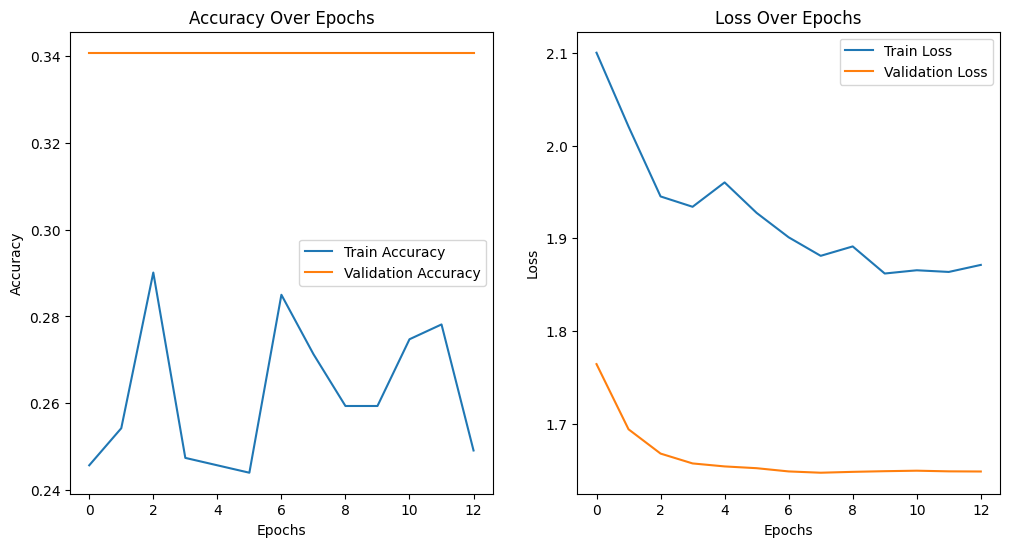

In [57]:
# Step 6: Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [ ]:
# Save the model
model.save("SegNet.h5")
print("Model saved.")

Model saved.
